<a href="https://colab.research.google.com/github/Ebadi-Fereshteh/Deep-Learning/blob/main/49_DCGAN/Fashion_Mnist/49_DCGAN_fashionMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D, BatchNormalization, Flatten, LeakyReLU,ReLU, Reshape, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import time
from IPython import display
import PIL
import glob
import imageio

In [ ]:
(train_data, train_label),(_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
# Reshape data
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1).astype('float32')
# Normalize the images to [-1, 1]
train_data = (train_data - 127.5)/ 127.5

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
# Batch and shuffle the data
train_batchData = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##**Models**

In [ ]:
generator_model = tf.keras.Sequential([
        Dense(7*7*256, use_bias=False, input_shape=(100,)),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 256)),
        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias= False),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias= False, activation='tanh')       

])


In [ ]:
generator_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_13 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 14, 14, 128)      819200    
 ranspose)                                                       
                                                                 
 batch_normalization_14 (Bat  (None, 14, 14, 128)     

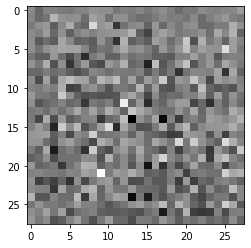

In [ ]:
# Random noise generated before model training:
noise = tf.random.normal([1, 100])
generated_image = generator_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
discriminator_model = tf.keras.Sequential([
    Conv2D(64, (5, 5), strides=(1, 1), padding='same', input_shape=[28, 28, 1]),
    LeakyReLU(),
    # Dropout(0.3),
    # Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
    # LeakyReLU(),
    # Dropout(0.3),
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Flatten(),
    Dropout(0.3),
    Dense(2)
])


In [ ]:
discriminator_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 28, 28, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 2)                

In [ ]:
# Decision result before model training:
decision = discriminator_model(generated_image)
print(np.argmax(decision))

0


## **Loss Function**

In [ ]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
def generator_Loss(fake_output):
  return loss_function(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = loss_function(tf.ones_like(real_output), real_output),
  fake_loss = loss_function(tf.zeros_like(fake_output), fake_output),
  total_loss = (real_loss + fake_loss) 
  return total_loss

##**Optimizer**

In [ ]:
LR = 0.0002
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LR, beta_1= 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5)

##**Save weights**

In [ ]:
checkpoint_dir = '.\training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer= generator_optimizer,
              generator=generator_model,
              discriminator_optimizer=discriminator_optimizer,
              discriminator=discriminator_model)

##**Hyper parameters**

In [ ]:
EPOCHS = 50
noise_dim = 100
num_example_to_generate = 16
seed = tf.random.normal([num_example_to_generate, noise_dim])

##**Train**

In [ ]:
@tf.function
def train_step(real_images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator_model(noise, training=True)
    real_output = discriminator_model(real_images, training=True)
    fake_output = discriminator_model(generated_images, training=True)
    
    gen_loss = generator_Loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_genarator = gen_tape.gradient(gen_loss, generator_model.trainable_variables) 
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_genarator, generator_model.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))



In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in tqdm(dataset):
      train_step(image_batch)
    
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator_model, epoch+ 1, seed)

    # Save the model every 15 epochs
    if(epoch+ 1) % 15==0:
      checkpoint.save(file_prefix= checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch +1, time.time()- start))
    
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_model, epochs, seed)


In [ ]:
def generate_and_save_images(model, epoch, test_images):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_images, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0]* 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


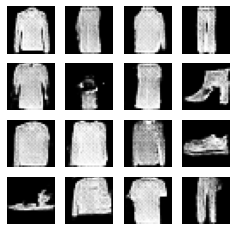

In [ ]:
train(train_batchData, EPOCHS)

In [ ]:
#Restore the latest checkpoint.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

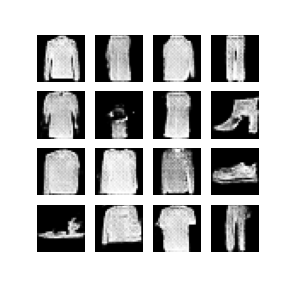

In [ ]:
display_image(EPOCHS)

In [ ]:
# Use imageio to create an animated gif using the images saved during training.
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
!pip install git+https://github.com/tensorflow/docs


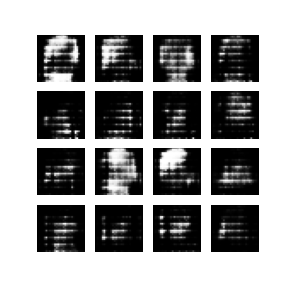

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)